In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, rdDepictor

rdDepictor.SetPreferCoordGen(True)

from sklearn.decomposition import KernelPCA

IPythonConsole.ipython_useSVG=True

%matplotlib inline

In [2]:
fdg = pd.read_csv("fdg.csv", index_col=0)

nist_uq_preds = pd.read_csv("uq_nist_pred.csv")
qin_uq_preds = pd.read_csv("gnn-uq-pred.csv")

qin_uq_preds["SMILES"] = qin_uq_preds["smiles"]

predictions_df = pd.concat([qin_uq_preds, nist_uq_preds], ignore_index=True)

In [3]:
fdg["SMILES"].compare(predictions_df["SMILES"])

,self,other


In [4]:
fdg["uq_pred"] = predictions_df["pred"]
fdg["uq_stddev"] = predictions_df["stddev"]

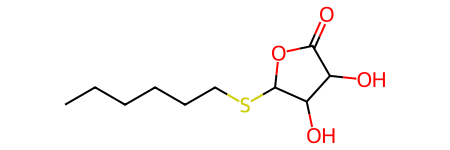

In [5]:
REF_COMPOUND = 80
KERNEL_ENTRY = f"K{REF_COMPOUND}"

ref_entry = fdg.iloc[REF_COMPOUND]
ref_mol = Chem.MolFromSmiles(ref_entry["SMILES"])
ref_mol

In [6]:
fdg.loc[:,KERNEL_ENTRY].describe()

count    2.450000e+02
mean     3.210371e+00
std      8.714964e-01
min      5.467796e-24
25%      2.571315e+00
50%      3.608589e+00
75%      3.868975e+00
max      4.370358e+00
Name: K80, dtype: float64

In [7]:
if "1d_kernel" not in fdg.columns:
    kpca = KernelPCA(n_components=1, kernel="precomputed")
    kernel_cols = [col for col in fdg.columns if col.startswith("K")]
    kernel_mat = fdg.loc[:, kernel_cols].values
    kernel_loc = kpca.fit_transform(kernel_mat)
    fdg["1d_kernel"] = kernel_loc

## Determine which to plot

We're going to find an area on the FDG layout that contains a given number of `test` compounds. To do this, we find the absolute displacement, in each dimension, of all the `test` compounds from the reference. Then, take the largest displacement. Sort these values from smallest to largest and pick the `N`th largest, where `N` is the number we want to plot.

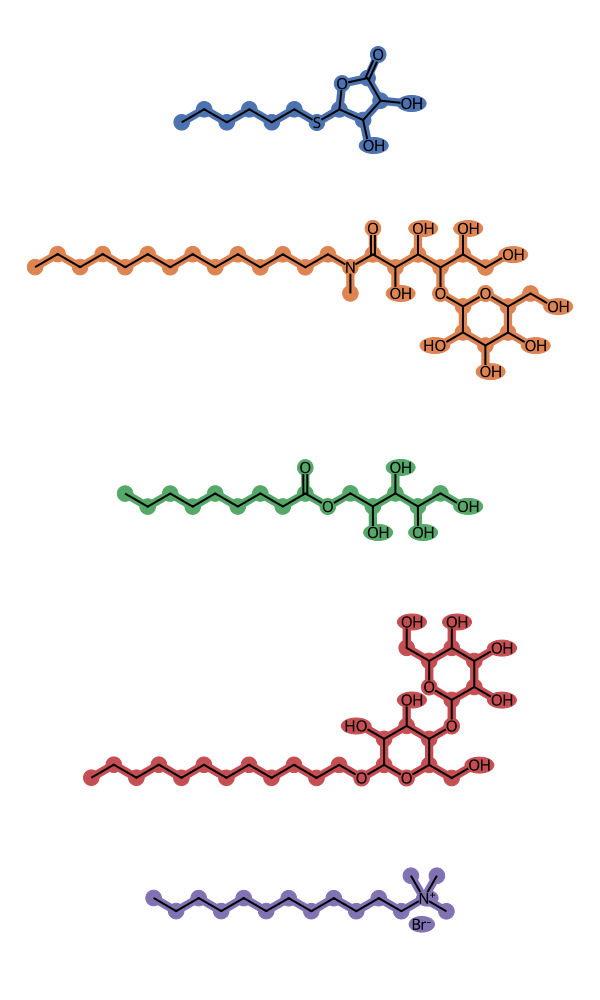

In [8]:
NUM_TO_PLOT = 5

pal = sns.color_palette("deep", n_colors=NUM_TO_PLOT)
list_pal = list(pal)

fdg.loc[:, "x_displace"] = (fdg["x"] - ref_entry["x"]).abs()
fdg.loc[:, "y_displace"] = (fdg["y"] - ref_entry["y"]).abs()
fdg.loc[:, "max_displace"] = fdg.loc[:, ["x_displace", "y_displace"]].max(1)

fdg_test = fdg[fdg["traintest"] == "test"]

most_similar = fdg_test.nsmallest(NUM_TO_PLOT, "max_displace")
displace_limit = most_similar["max_displace"].max()

similar_mols = [Chem.MolFromSmiles(smiles) for smiles in most_similar["SMILES"]]

highlight_idxs = []
highlight_colors = []
for i, mol in enumerate(similar_mols):
    idxs = [atom.GetIdx() for atom in mol.GetAtoms()]
    highlight_idxs.append(idxs)
    color_map = {idx: list_pal[i] for idx in idxs}
    highlight_colors.append(color_map)


bw_options = Draw.MolDrawOptions()
bw_options.useBWAtomPalette()
bw_options.clearBackground = True

Draw.MolsToGridImage(
    similar_mols,
    molsPerRow=1,
    subImgSize=(600, 200),
    highlightAtomLists=highlight_idxs,
    highlightAtomColors=highlight_colors,
    drawOptions=bw_options,
)

In [9]:
example_entry = most_similar.iloc[0]
print(example_entry["uq_pred"])


3.560231933355152


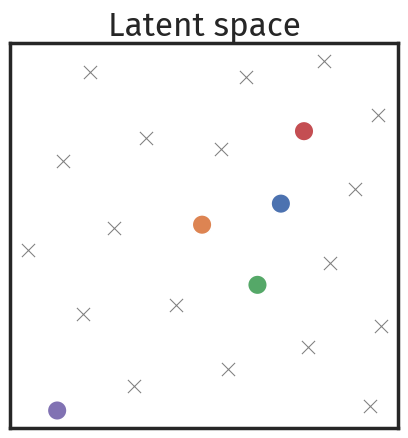

In [12]:
sns.set_theme(context="poster", style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font="Fira Sans")

PAPERWHITE =  "w"

within_bounds = fdg["max_displace"].le(displace_limit)
just_train_mols = within_bounds & (fdg["traintest"] == "train")
just_test_mols = within_bounds & (fdg["traintest"] == "test")

fig, ax = plt.subplots(figsize=(7, NUM_TO_PLOT))
sns.scatterplot(fdg[just_train_mols], x="x", y="y", color="gray", legend=False, ax=ax, marker="x", s=90)
sns.scatterplot(fdg[just_test_mols], x="x", y="y", hue="SMILES", palette=pal, legend=False, ax=ax, s=200, edgecolor=PAPERWHITE)
ax.set(yticks=[], xticks=[], ylabel="", xlabel="")
ax.set_aspect("equal")

plt.title("Latent space")
plt.savefig("latent_subspace.svg", transparent=True)

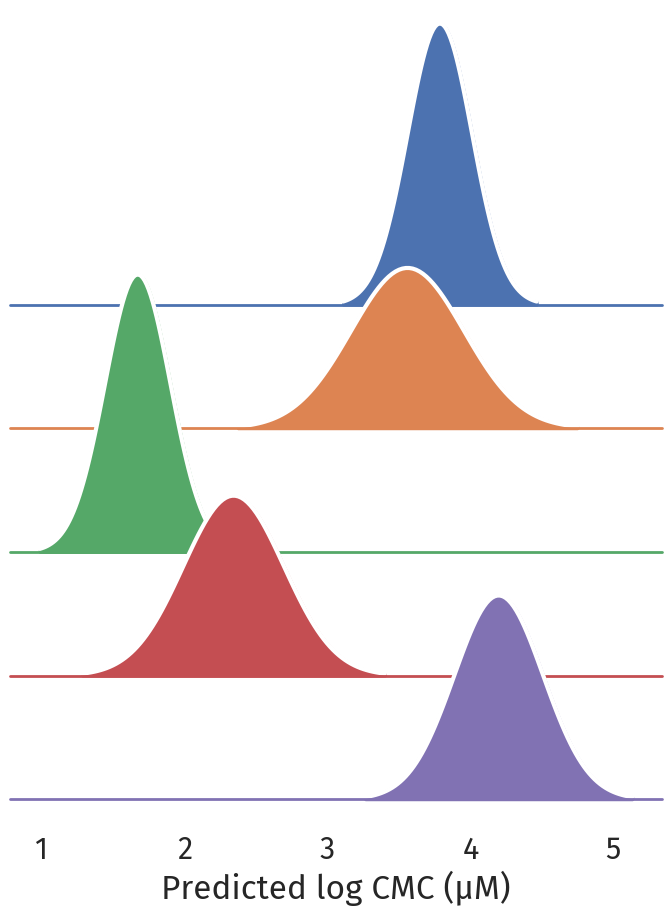

In [13]:
g = sns.FacetGrid(fdg[just_test_mols], row="SMILES", hue="SMILES", palette=pal, aspect=4, height=2)

def norm_plot(mean: pd.Series, stddev: pd.Series, outline = False, *args, **kwargs):
    RANGE = 3

    mean = mean.item()
    stddev = stddev.item()

    ax = plt.gca()
    x = np.linspace(mean - RANGE * stddev, mean + RANGE * stddev, 100)
    y = stats.norm.pdf(x, mean, stddev)
    if outline:
        lineplot_kws = {"color": PAPERWHITE, "lw": 3}
    else:
        lineplot_kws = {"lw": 1.5}
        ax.fill_between(x, y, **kwargs)

    kwargs.update(lineplot_kws)
    sns.lineplot(x=x, y=y, *args, **kwargs, clip_on=False)

g.map(norm_plot, "uq_pred", "uq_stddev")
g.map(norm_plot, "uq_pred", "uq_stddev", outline=True)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

g.figure.subplots_adjust(hspace=-.6)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Predicted log CMC (μM)")
g.despine(bottom=True, left=True)

g.savefig("gaussian_ridges.svg", transparent=True)